In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import csv

Populating the interactive namespace from numpy and matplotlib


Function dictionary

In [2]:
# Calculate E(z), which in this situation depends on w
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w)))
    return E

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, w, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, w, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

# -----------------------------------------------------------------------------------

# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, w, omega_m, omega_l):

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l

    # Calculate D_M/D_H for different universe geometries
    # open universe (omega_k > 0)
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z,w,omega_m,omega_l) )
    # closed universe (omega_k < 0)
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z,w,omega_m,omega_l) )
    # flat universe (omega_k = 0)
    else:
        return 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) )

# proper motion distance for omega_l != 0
def prop_motion(z, w, omega_m, omega_l):
        
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    
    # Calculate D_C/D_H integral
    DCDH = DCDH_int(z,w,omega_m,omega_l)
    
    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH )
    # closed universe
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH )
    # flat universe
    else:
        return DCDH

# --------------------------------------------------------------------------------------------

# distance modulus

def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    
    # initialize the distance modulus value
    mu = 0.0
    
    # convert D_H from Mpc to pc
    DH = D_H * 1.0e6
    
    # Determine D_M/D_H
    if (omega_l == 0):
        DMDH = prop_motion_0(z, w, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, w, omega_m, omega_l)

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    
    return mu

Variable dictionary

In [3]:
# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Parameters we are trying to find
omega_m = None                  # mass density parameter
w = None                        # equation of state
dm_offset = None                # offset of the model from the data

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots
npts = None                     # Number of points (omega_m, w) we use

# Output arrays
z = None;                       # Array of input values of z
DMDH = np.array([])             # Array of output values of D_M/D_H
DADH = np.array([])             # Array of output values of D_A/D_H
DLDH = np.array([])             # Array of output values of D_L/D_H
dmod = np.array([])             # distance modulus array
DVC = np.array([])              # comoving volume array
tLtH = np.array([])             # Array of lookback times
age = np.array([])              # Array of ages
dPdz = np.array([])             # dimensionless intersection probability

# Calculate Hubble distance
H = 70.0                        # Hubble constant
D_H = c / H                     # Hubble distance

Extract redshifts and distance moduli from text file

In [4]:
# Begin by collecting csv data and making a scatter plot of it
zs = []
dm_obs = []
sigmas = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
    i = 0
    for row in ps1_data:
        if (i > 0):
            zs.append(float(row[1]))
            dm_obs.append(float(row[4]))
            sigmas.append(float(row[5]))
        i+= 1
        
#plt.scatter(zs, dm_obs)

In [5]:
#print('z\tdm')
#for z, dm in zip(zs, dm_obs):
#    print('{:.3f}\t{:.3f}'.format(z, dm))

Proposal

In [6]:
# proposal function q(x'|x) where x is a 2-component vector
def q(x):
    # draw from a multivariate gaussian with mean [0,0] and covariance matrix I
    # Add the randomly drawn number to x and return the sum
    mu = np.array([0.0, 0.0, 0.0])
    sigma = np.matrix([ [1.0,0.0,0.0], [0.0,1.0,0.0], [0.0,0.0,1.0] ])    # covariance matrix
    q = stats.multivariate_normal.rvs(mean=mu, cov=sigma)
    return x + q

Part (a)

In [7]:
# density function f(x) is the log likelihood of the data given parameters
# takes a vector x = (x1, x2) as input
def make_log_likelihood(zs, D_H):
    
    def log_likelihood(omega_m, w, dm_offset):
        
        # Assume a flat universe, i.e. omega_l = 1 - omega_m
        omega_l = 1.0 - omega_m
                
        # initialize the log likelihood function
        ln_likelihood = 0.0

        # loop for all values of z in the z-array
        for i in range(len(zs)):
            
            # initialize for each iteration
            z_i = zs[i]
            sigma_dm_i = sigmas[i]
            dm_obs_i = dm_obs[i]
            
            # calculate predicted value of distance modulus based on z-value and parameters
            DMDH_i = prop_motion(z_i, w, omega_m, omega_l)    # proper motion distance
            dm_pred_i = dist_mod(z_i, D_H, omega_m, omega_l, DMDH_i) + dm_offset    # distance modulus

            # calculate each term
            term = np.log(1.0 / (sigma_dm_i*np.sqrt(2.0*np.pi))) \
            - 0.5 * (dm_obs_i-dm_pred_i) * (dm_obs_i-dm_pred_i) / (sigma_dm_i*sigma_dm_i)

            # increment log-likelihood
            ln_likelihood += term

            # print statement to debug code
            #print("x: " + str(xi) + " | sigma: " + str(sigma_i) + " | Term being added: " + str(term))
            
        return ln_likelihood
        
    return log_likelihood

Run MCMC

In [9]:
# Create the lnf function
lnf = make_log_likelihood(zs, D_H)

# Markov chain
mchain = [[0.0,0.0,0.0]]    # array of V, R ordered pairs 
                         # for the Hubble distance and and z-value

for i in range(100):
    
    # Take the last entry in the Markov chain
    params = mchain[-1]
    
    omega_m = params[0]
    w = params[1]
    dm_offset = params[2]

    # propose a new point in the parameter space
    params_new = q(params)
    
    omega_m_new = params_new[0]
    w_new = params_new[1]
    dm_offset_new = params_new[2]
    
    # accept if acceptance ratio is greater than 
    # a randomly generated value from 0 to 1
    accept_diff = lnf(omega_m_new, w_new, dm_offset_new) - lnf(omega_m, w, dm_offset)
    if math.log(rand()) < accept_diff:
        mchain.append(params_new)
    else:
        mchain.append(params)
    
    print("i = " + str(i))

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56


<ipython-input-2-0e9f940a502b>:4: RuntimeWarning: invalid value encountered in sqrt
  E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w)))
<ipython-input-2-0e9f940a502b>:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  i = integrate.quad(f, 0, z_limit)


i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99


In [ ]:
#plot(xs)

In [10]:
# Extract V- and R-coordinates from the array of vectors
omegams = []    # list of omega_m values
ws = []         # list of w values
offsets = []    # list of dm offsets

for i in mchain:
    omegams.append(i[0])
    ws.append(i[1])
    offsets.append(i[2])
    print("length of each array: " + str(len(omegams)))
    # Variation of the loop: use an if statement to omit burn-in points
    #for i in VRs:
    #

length of each array: 1
length of each array: 2
length of each array: 3
length of each array: 4
length of each array: 5
length of each array: 6
length of each array: 7
length of each array: 8
length of each array: 9
length of each array: 10
length of each array: 11
length of each array: 12
length of each array: 13
length of each array: 14
length of each array: 15
length of each array: 16
length of each array: 17
length of each array: 18
length of each array: 19
length of each array: 20
length of each array: 21
length of each array: 22
length of each array: 23
length of each array: 24
length of each array: 25
length of each array: 26
length of each array: 27
length of each array: 28
length of each array: 29
length of each array: 30
length of each array: 31
length of each array: 32
length of each array: 33
length of each array: 34
length of each array: 35
length of each array: 36
length of each array: 37
length of each array: 38
length of each array: 39
length of each array: 40
length of

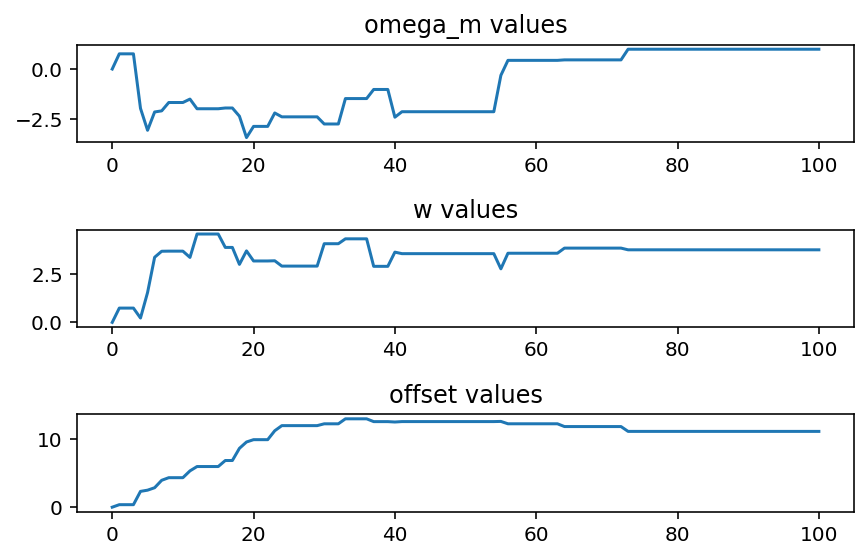

In [12]:
# Trace the evolution of V and R values over iterations
subplot(311)
title('omega_m values')
plot(omegams)

subplot(312)
title('w values')
plot(ws)

subplot(313)
title('offset values')
plot(offsets)

tight_layout()

show()

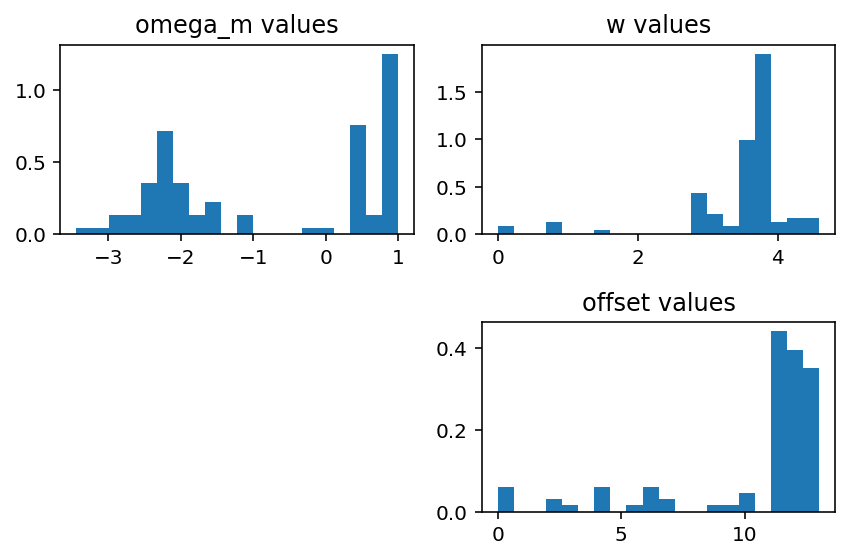

In [14]:
    
# Generate 1-dimensional histograms of V- and R-coordinates and 2-dimensional scatterplot
subplot(221)
title('omega_m values')
hist(omegams, density=True, bins=20)

subplot(222)
title('w values')
hist(ws, density=True, bins=20)

subplot(224)
title('offset values')
hist(offsets, density=True, bins=20)

#subplot(223)
#title('R vs V')
#scatter(Vs, Rs)
#plt.xlabel('V')
#plt.ylabel('R')

tight_layout()

show()